In [46]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import DenseNNDecoder

#Import hyperparameter optimization packages
#If either are not installed, give a warning
try:
    from bayes_opt import BayesianOptimization
except ImportError:
    print("\nWARNING: BayesianOptimization package is not installed. You will be unable to use section 4.")
    pass

try:
    from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
except ImportError:
    print("\nWARNING: hyperopt package is not installed. You will be unable to use section 5.")
    pass


In [92]:
###Load Data###
folder='' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/' 
data=io.loadmat(folder+'jeb7_decoding.mat')

latents_avg = data['latents_avg']
latents = data['latents']
latents = latents[:,[0,1,3,4,5,6]]
jawPos = data['jawPos']
jawVel = data['jawVel']
jawAcc = data['jawAcc']

In [93]:
bins_before=10 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=3 #How many bins of neural data after the output are used for decoding

In [94]:
# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(latents,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

In [95]:
#Set decoding output
y=jawPos

In [96]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

In [97]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21845/2031062748.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21845/2031062748.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`,

In [98]:
#Z-score "X" inputs. 
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/X_train_std
X_test=(X_test-X_train_mean)/X_train_std
X_valid=(X_valid-X_train_mean)/X_train_std

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

In [87]:
def dnn_evaluate(num_units,frac_dropout,n_epochs):
    #The parameters need to be in the correct format for the decoder, so we do that below
    num_units=int(num_units)
    frac_dropout=float(frac_dropout)
    n_epochs=int(n_epochs)
    #Declare and fit decoder
    model_dnn=DenseNNDecoder(units=[num_units,num_units],dropout=frac_dropout,num_epochs=n_epochs)
    model_dnn.fit(X_flat_train,y_train)
    #Make predictions and get R2 values on validation set
    y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)
    return np.mean(get_R2(y_valid,y_valid_predicted_dnn))

In [48]:
#Do bayesian optimization, and set limits of hyperparameters
dnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 700.99), 'frac_dropout': (0,.5), 'n_epochs': (2,15.99)},verbose=0)

#Set number of initial runs (init_points) and subsequent tests (n_iter), and do the optimization
#kappa is a parameter that sets exploration vs exploitation in the algorithm - 10 seems to work pretty welldnnBO = BayesianOptimization(dnn_evaluate, {'num_units': (50, 500), 'frac_dropout': (0.,.5), 'n_epochs': (2,15)})
dnnBO.maximize(init_points=10, n_iter=10, kappa=10)

In [56]:
#Print out the best parameters and associated R2 value
dnnBO.max

{'target': 0.13637453202762623,
 'params': {'frac_dropout': 0.4015804278906534,
  'n_epochs': 5.787722193552698,
  'num_units': 298.7055509412827}}

In [59]:
#Assign the best hyperparameters to variables, and put them in the correct format
best_params=dnnBO.max
frac_dropout=float(best_params['params']['frac_dropout'])
n_epochs=np.int(best_params['params']['n_epochs'])
num_units=np.int(best_params['params']['num_units'])

/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21845/711500670.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_epochs=np.int(best_params['params']['n_epochs'])
/var/folders/8z/7700l6954h7904db5vm_r6900000gn/T/ipykernel_21845/711500670.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

In [99]:
num_units = 298
frac_dropout = 0.40158
n_epochs = 5

print(frac_dropout)
print(n_epochs)
print(num_units)

0.40158
5
298


In [100]:
#Declare model
model_dnn=DenseNNDecoder(units=num_units,dropout=frac_dropout,num_epochs=n_epochs)

#Fit model
model_dnn.fit(X_flat_train,y_train)

#Get predictions
y_valid_predicted_dnn=model_dnn.predict(X_flat_valid)

#Get metric of fit
R2s_dnn=get_R2(y_valid,y_valid_predicted_dnn)
print('R2s:', R2s_dnn)


R2s: [0.04827191 0.08960967]


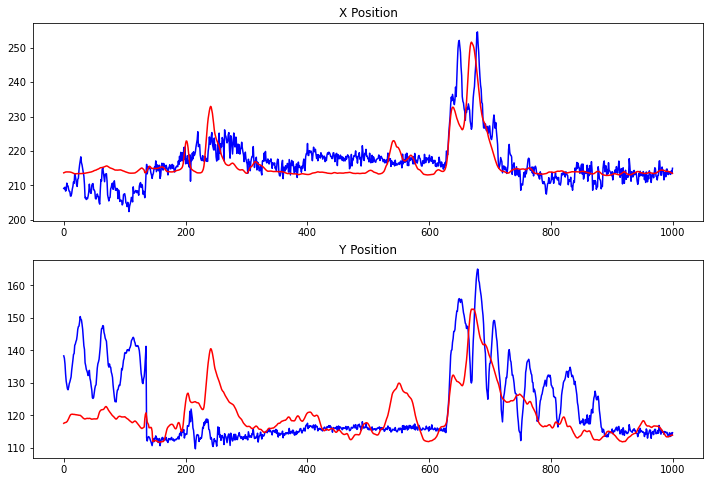

In [103]:
y_valid_predicted = y_valid_predicted_dnn

nIdx = y_valid.shape[0]
nIdx = nIdx - 1001
low = np.random.randint(0, high=nIdx)
randTime = np.arange(low,low+1000)

fig, axs = plt.subplots(2, 1,figsize=(12,8))
feat = 0
axs[0].plot(y_valid[randTime,feat]+y_train_mean[feat],'b')
axs[0].plot(y_valid_predicted[randTime,feat]+y_train_mean[feat],'r')
axs[0].set_title('X Position')

feat = 1
axs[1].plot(y_valid[randTime,feat]+y_train_mean[feat],'b')
axs[1].plot(y_valid_predicted[randTime,feat]+y_train_mean[feat],'r')
axs[1].set_title('Y Position')

plt.show()